## Testing CNN implentation with Keras

In [1]:
# Pathing Libraries
from pathlib import Path
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
import os.path as op
import glob

# Image Libraries
import nibabel as nib
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
import tensorflow_transform as tft
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

## Limits memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2024-02-12 13:48:42.523958: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 13:48:42.524001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 13:48:42.524883: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-12 13:48:42.530574: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-12 13:48:43.371159: W tensorflow/compiler/tf2

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


2024-02-12 13:48:44.141088: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-12 13:48:44.164136: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-12 13:48:44.164242: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-12 13:48:44.167033: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-12 13:48:44.167119: I external/local_xla/xla/stream_executor

In [3]:
## Pathing
path = '../'

images_path = Path(path, 'data', 'images')
masks_path = Path(path, 'data', 'masks')
segs_path = Path(path, 'data', 'segs_refs')
metadata_path = Path(path, 'data', 'meta')

## z_normalize function for images - Converts numpy arrays to tensors (uses VRAM instead of RAM)
def z_normalize(img_data, mask_data):
    # Ensure the mask is binary and convert to float
    mask_data = tf.cast(tf.where(mask_data > 0, 1, 0), tf.float32)

    # Apply the mask to the image
    masked_image_data = tf.math.multiply(img_data, mask_data)

    # Calculate the mean and standard deviation of the masked image
    mean, std_dev = tf.nn.moments(masked_image_data, axes=[0])

    # Calculate the z-score of the masked image
    masked_image_data = tf.where(mask_data==0, (masked_image_data - mean) / std_dev, masked_image_data)

    # Handle NaN values that might result from zscoring zero-valued elements
    masked_image_data = tf.where(tf.math.is_nan(masked_image_data), tf.zeros_like(masked_image_data), masked_image_data)

    return masked_image_data

In [4]:
meta_data = pd.read_csv(Path(metadata_path, 'meta_data_all.csv'))

raw_images = []
sub_counter = 0
for subj, age, gender in zip(meta_data['subject_id'], meta_data['age'], meta_data['gender_text']): # ''gender_code'; 1= male, 2= female
    # print(subj, age, gender)
    print(sub_counter, age)
    
    # Loading in Raw Image Data
    image = nib.load(op.join(images_path, 'sub-' + subj + '_T1w_unbiased' + '.nii.gz'))
    img_data = image.get_fdata()

    # Loading in Segmentation Data
    seg = nib.load(op.join(segs_path, 'sub-' + subj + '_T1w_seg.nii.gz'))
    seg_data = seg.get_fdata()

    # Loading in Mask Data
    mask = nib.load(op.join(masks_path, 'sub-' + subj + '_T1w_brain_mask' + '.nii.gz'))
    mask_data = mask.get_fdata()

    # Z-score Normalization
    z_img = z_normalize(img_data, mask_data)
#    raw_images.append(z_img)
    z_seg = z_normalize(seg_data, mask_data)
    raw_images.append(z_seg)

    sub_counter += 1


# Combines to a 4D numpy array: (652, 98, 116, 94) - subject, x, y, z
combined_scans = tf.stack(raw_images, axis=0) # Changed from np.stack to tf.stack
# Empty the list to free up memory
raw_images = []



CC110033 24 MALE
CC110037 18 MALE
CC110045 24 FEMALE
CC110056 22 FEMALE
CC110062 20 MALE
CC110069 28 FEMALE
CC110087 28 FEMALE
CC110098 23 MALE
CC110101 23 MALE
CC110126 22 FEMALE
CC110174 25 FEMALE
CC110182 18 FEMALE
CC110187 25 FEMALE
CC110319 28 FEMALE
CC110411 25 MALE
CC110606 20 MALE
CC112141 29 MALE
CC120008 26 MALE
CC120049 28 MALE
CC120061 19 MALE
CC120065 25 FEMALE
CC120120 25 MALE
CC120123 19 FEMALE
CC120166 28 MALE
CC120182 26 MALE
CC120208 24 FEMALE
CC120218 27 FEMALE
CC120234 24 FEMALE
CC120264 28 MALE
CC120276 23 FEMALE
CC120286 22 MALE
CC120309 27 MALE
CC120313 28 MALE
CC120319 27 FEMALE
CC120347 21 FEMALE
CC120376 18 FEMALE
CC120409 18 MALE
CC120462 18 FEMALE
CC120469 25 FEMALE
CC120470 28 FEMALE
CC120550 19 MALE
CC120640 26 FEMALE
CC120727 23 FEMALE
CC120764 27 MALE
CC120795 24 MALE
CC120816 23 MALE
CC120987 20 FEMALE
CC121106 28 FEMALE
CC121111 18 MALE
CC121144 26 MALE
CC121158 28 FEMALE
CC121194 24 FEMALE
CC121200 26 FEMALE
CC121317 25 FEMALE
CC121397 27 MALE
CC12141

In [5]:
print(type(combined_scans))
combined_scans.shape

<class 'tensorflow.python.framework.ops.EagerTensor'>


TensorShape([652, 98, 116, 94])

## Visualization Test

0 6
1 46
2 86
3 126


2024-02-12 13:49:48.814222: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 126 of dimension 1 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 126 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/

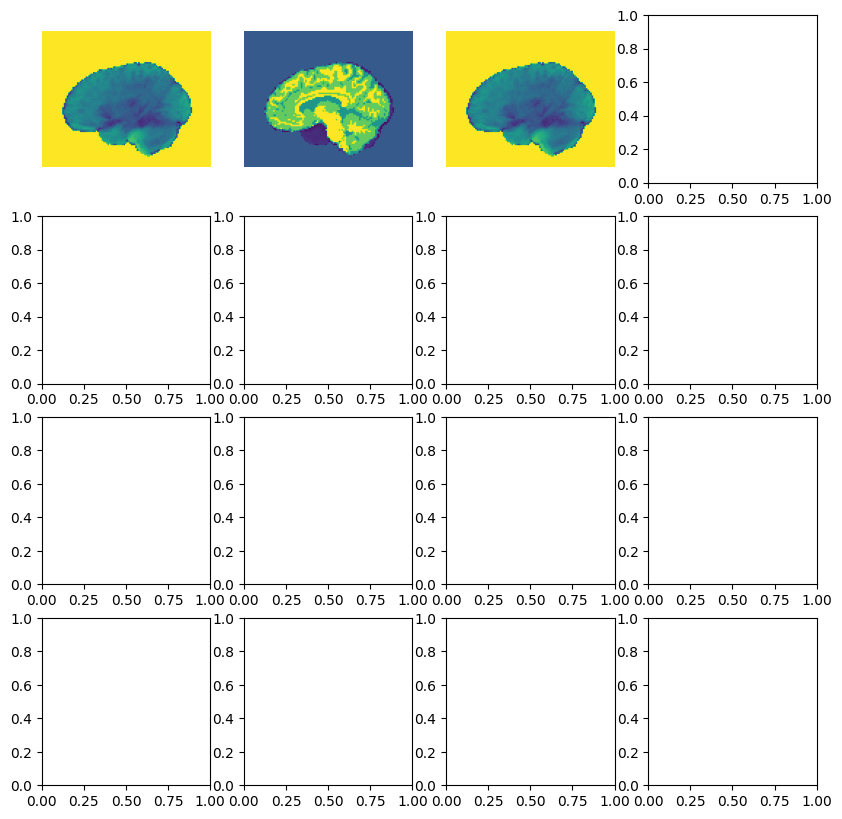

In [6]:
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = combined_scans.shape[0]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    print(idx, img)
    axs.flat[idx].imshow(ndi.rotate(combined_scans[0,img, :, :], 90), cmap='viridis')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'axs'

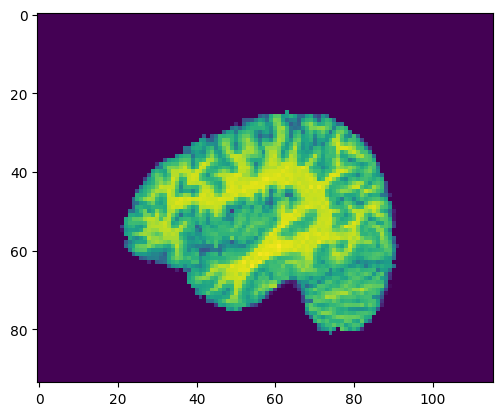

In [19]:

plt.imshow(ndi.rotate(combined_scans[1,30,:,:], 90), cmap='viridis')
plt.axs('off')
plt.show()

## Image Segmentation

In [6]:
from sklearn.model_selection import train_test_split

TensorFlow version: 2.15.0


In [4]:
#tf.keras.utils.image_dataset_from_directory??
#https://peerherholz.github.io/workshop_weizmann/advanced/machine_learning_keras.html
tf.keras.utils.image_dataset_from_directory(images_path)

Found 0 files belonging to 0 classes.


ValueError: No images found in directory ..\data\images. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

In [6]:
# Create Model
model = tf.keras.models.Sequential([

TensorFlow version: 2.13.0
